<a href="https://colab.research.google.com/github/JonathanNdambaPro/Etude_de_cas/blob/master/Etude_de_cas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install eli5
!pip install pdpbox
!pip install shap
!pip install lightgbm --upgrade
!pip install hyperopt --upgrade
!pip install plotly --upgrade
!pip install mlxtend --upgrade
!pip install sklearn --upgrade


import os 
import pandas as pd 
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from typing import List, Dict, Tuple
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np 
import chardet

drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/Etude_de_cas')
train_data = pd.read_csv('data - etude de cas.csv')

datetime: 

    date et heure du relevé

season: 
    
     1 = printemps
     2 = été
     3 = automne
     4 = hiver

holiday:
    
     indique si le jour est un jour de vacances scolaires

workingday: 

    indique si le jour est travaillé (ni week-end ni vacances)

weather :

     1 - Dégagé à nuageux
     2 - Brouillard
     3 - Légère pluie ou neige
     4 - Fortes averses ou neiges


temp: 

    température en degrés Celsius

atemp:

    température ressentie en degrés Celsius

humidity:

    taux d’humidité

windspeed:

    vitesse du vent


casual:

    nombre de locations d’usagers non abonnés

registered:

    nombre de locations d’usagers abonnés

count:


    nombre total de locations de vélos

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  day         10886 non-null  int64         
 13  mouth       10886 non-null  int64         
 14  year        10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(11)
memory usage: 1.2 MB


On verifie si il y a des donnees manquantes

In [3]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


On se fait une petite idee de nos donnees

In [6]:
corr = train_data.corr()
name_columns = corr.columns.to_list()
data = corr.to_numpy()

fig = px.imshow(data,
                labels=dict(x="Features", y="Features", color="Correlation"),
                x=name_columns,
                y=name_columns,
                width=1000, height=1000
              )

fig.update_xaxes(side="top")
fig.show()

On se fait une idee des relations  lineaires entre nos donnees


In [41]:
def multicolinearity_dectection(corr: pd.DataFrame, seuil: float) -> List:
  """
  Prend en entrer une matrice de correlation et retourne une liste de tuple des variables tres correlee
  corr: pd.DataFrame
  seuil: float
  rtype: List[tuple]
  """
  columns_corr = corr.columns
  multicolinearity = []
  for col in columns_corr:
    corr_var = corr[col][corr[col] > seuil].index
    multicolinearity += [(col, w) for w in corr_var if w != col and (w, col) not in multicolinearity]

  return multicolinearity


multicolinearity_dectection(corr, 0.75)

[('temp', 'atemp'), ('registered', 'count')]

temp et atemp sont tres correles on devra utiliser la norme L2 pour ne pas tomber dans le piege de multicolinearite

In [8]:
target = "count"

x = corr[target].sort_values(ascending=True)
y = corr[target].sort_values(ascending=True).index

fig = go.Figure(data=[go.Bar(x=x, y=y, orientation='h')],
                layout=go.Layout(height=1000, width=1500))
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Correlation avec SalePrice')
fig.show() 

On peut voir que casual registred et temp capture enormement d'information sur la cible count un modele lineaire faire l'affaire

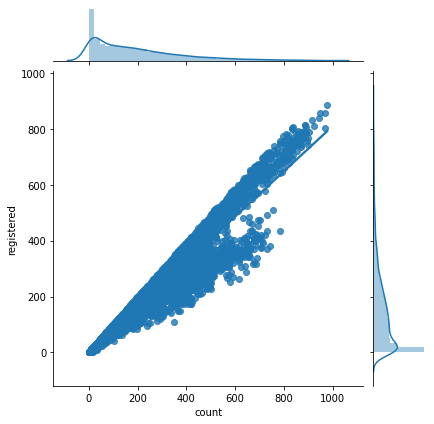

In [23]:
g = sns.jointplot(target, "registered", data=train_data, kind="reg")

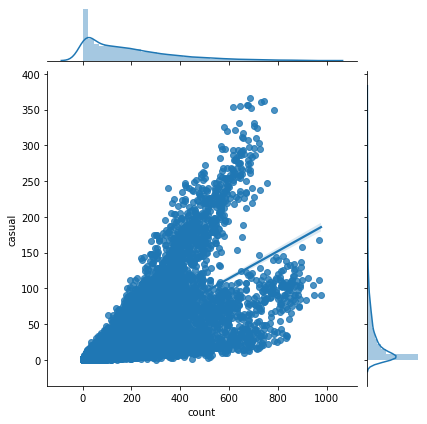

In [25]:
g = sns.jointplot(target, "casual", data=train_data, kind="reg")

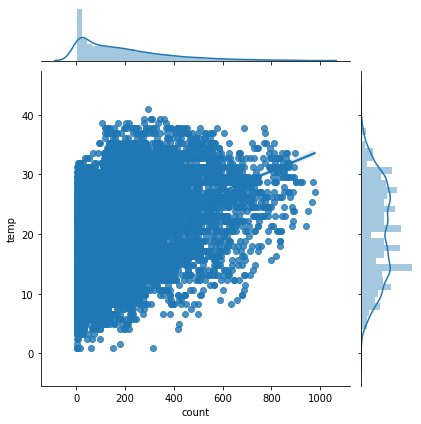

In [26]:
g = sns.jointplot(target, "temp", data=train_data, kind="reg")

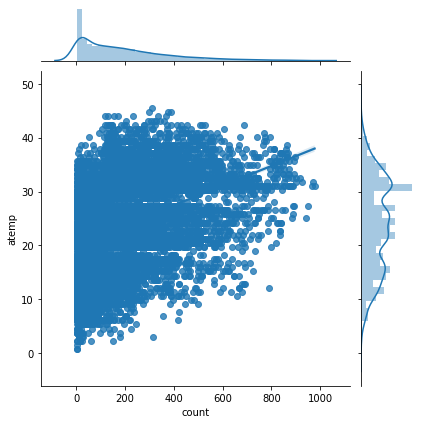

In [27]:
g = sns.jointplot(target, "atemp", data=train_data, kind="reg")

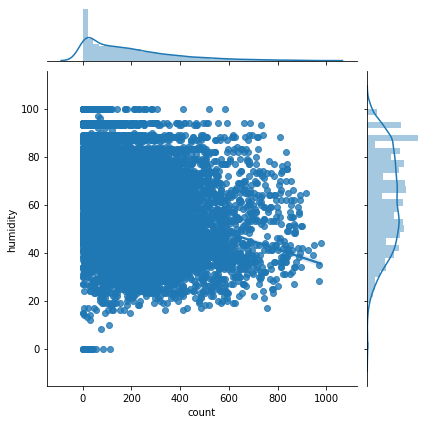

In [30]:
g = sns.jointplot(target, "humidity", data=train_data, kind="reg")

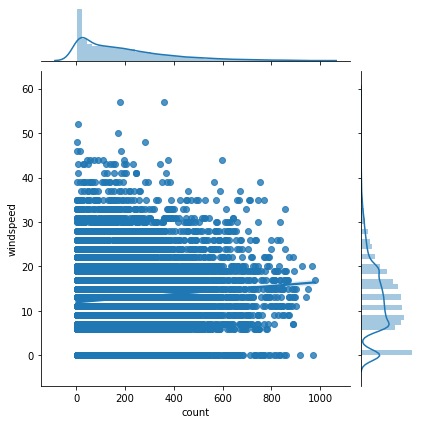

In [59]:
g = sns.jointplot(target, "windspeed", data=train_data, kind="reg")

In [11]:
train_data.datetime = pd.to_datetime(train_data.datetime)

In [14]:
def plot_time(target: str, Year:str) -> None:
  df = train_data.groupby(by=Year).mean()[target].reset_index()
  fig = px.line(df, y=target, x=Year)
  fig.show()


plot_time(target, 'datetime')

In [70]:
train_data["day"] = train_data.datetime.dt.day
train_data["mouth"] = train_data.datetime.dt.month
train_data["year"] = train_data.datetime.dt.year
train_data["hour"] = train_data.datetime.dt.hour


In [32]:
def box_plot(train_data: pd.DataFrame, x:str) -> None:
  fig = px.box(train_data, x=x, y=target)
  fig.show()


box_plot(train_data, "day")

In [71]:
box_plot(train_data, "hour")

In [35]:
plot_time(target, 'day')

In [33]:
box_plot(train_data, "mouth")

In [36]:
plot_time(target, 'mouth')

In [34]:
box_plot(train_data, "year")

In [37]:
box_plot(train_data, "season")

In [38]:
box_plot(train_data, "holiday")

In [39]:
box_plot(train_data, "workingday")

In [40]:
box_plot(train_data, "weather")

In [104]:
from scipy import stats

X_reg = train_data.copy()
noise = 0.1

columns_to_transform = ["casual", target, "registered"]
for col in columns_to_transform:
  X_reg[col]  = X_reg[col] + noise
  X_reg[col]  = stats.boxcox(X_reg[col])[0]


X_reg = X_reg.drop("datetime", axis=1)


In [105]:
from sklearn.preprocessing import RobustScaler

cat_columns = ["season", "weather", "day", "mouth",	"year",	"hour"]
X_reg[cat_columns] = X_reg[cat_columns].astype(str)
train_data_num = X_reg.select_dtypes(exclude='object')
train_data_cat = X_reg.select_dtypes(include='object')

num_attribs = train_data_num.columns.to_list()
cat_attribs = train_data_cat.columns.to_list()

train_data_cat_dummies = pd.get_dummies(train_data_cat)


num_pipeline_reg = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', RobustScaler(quantile_range=(0.01, 0.99))),
    ])


train_data_num_reg = num_pipeline_reg.fit_transform(train_data_num)
train_data_num[num_attribs]= train_data_num_reg
train_data_reg = pd.concat([train_data_num, train_data_cat_dummies], axis=1)

X_reg = train_data_reg.drop([target], axis=1)

Y = train_data_reg[target]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [109]:
from sklearn.linear_model import ElasticNet
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score


SPACE_REG = {
    'alpha': hp.uniform('alpha', 0.01, 5),
    'l1_ratio': hp.uniform('l1_ratio', 0.01, 5),
    }

def hyperopt_train_test_reg(params: Dict, X: pd.DataFrame, Y: pd.DataFrame) -> float:
  clf = ElasticNet(**params)
  scores = cross_val_score(clf, X, Y, cv=5, n_jobs=-1, scoring='r2')
  neg_R2_mean = -scores.mean()
  return neg_R2_mean

def f(params: Dict):
    R2 = hyperopt_train_test_reg(params, X_reg, Y)
    return {'loss': R2, 'status': STATUS_OK}

trials = Trials()


def find_best_param(f, SPACE: Dict, trials) -> Dict:
  best = fmin(f, SPACE_REG, algo=tpe.suggest, 
                max_evals=100, trials=trials)
  return best

best = find_best_param(f, SPACE_REG, trials)

100%|██████████| 100/100 [00:34<00:00,  2.86trial/s, best loss: -0.9954922341054179]


In [111]:
clf = ElasticNet(**best)
clf.fit(X_reg, Y)

ElasticNet(alpha=0.03783194532854267, copy_X=True, fit_intercept=True,
           l1_ratio=0.038679815339202506, max_iter=1000, normalize=False,
           positive=False, precompute=False, random_state=None,
           selection='cyclic', tol=0.0001, warm_start=False)

In [113]:
coef_reg = clf.coef_
name_features = X_reg.columns.to_list()
seuil = 0.05

column_coef_reg = [w for w in zip(coef_reg, name_features)]
column_coef_reg = [w for w in zip(coef_reg, name_features) if abs(w[0]) > seuil]

sorting_column_coef_reg = sorted(column_coef_reg, reverse=False)

coef_reg = [w[0] for w in sorting_column_coef_reg]
name_features = [w[1] for w in sorting_column_coef_reg]

fig = go.Figure(data=[go.Bar(x=coef_reg, y=name_features, orientation='h')],
                layout=go.Layout(height=1000, width=1500))

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Coefficient Regression (ElasticNet) des features les plus discriminantes')
fig.show() 

In [51]:
min(train_data["registered"])

0